# Classiq 6.12 - Final Assignment: Advanced Algorithms Design DISCRETE TIME QUANTUM WALK

### Author: Jyotiraj Nath (Womanium Scholar)

In [ ]:
!pip install classiq --quiet

In [ ]:
import classiq
classiq.authenticate(overwrite = True)

## Problem Statement Description:

Follow the example from <a href = "https://www.youtube.com/watch?v=kHJLwfDUSWI&list=PL_wGNAk5B0pXq98BJBKsbNH2Qjp1lk8dG&index=31&ab_channel=WOMANIUM">Bootamp -4 </a> for creating the quantum walk operator for the case of a circle with 4 nodes, and design the quantum walk operator for the case of a line with 16 nodes:
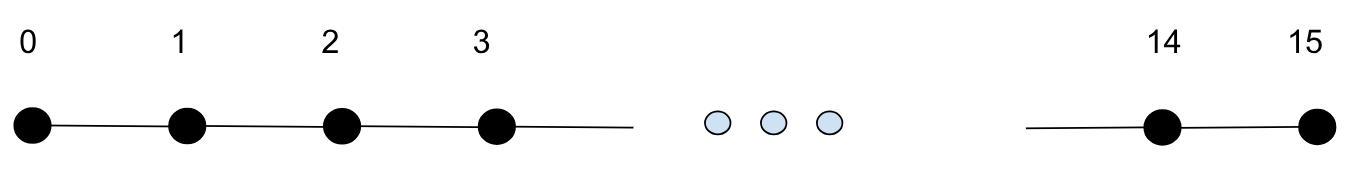
In the quantum walk topology for this problem, the 16 nodes (starting from 0 to 15) are connected with their intermediate neighbors and during the walk the walker moves to any adjacent nodes based on equal probability

## Describing Discrete Time Quantum Walk (DTQW):

Let us first define what do we mean by the general Classical Random Walk as Quantum walks (QWs) are the quantum mechanical equivalent of classical random walks.

In Classical Random Walks, we define about an particle named "walker" that moves stochastically around a discrete space [1 = Review on Quantum Walk]. In the simplest discrete-time random walk, at each time step we simply move from any given vertex to each of its neighbors with equal probability [2 = Lecture Notes on].


In The Discrete Time Quantum Walk **(DTQW)** the walker is governed by quantum physics effects and shows markedly distinct properties compared to a classical random walk. When we describe about DTQW we generally refer to the **coin based quantum walk** as there are some other implementations such as: **1. Szegedy quantum walk** [3 = Quantum speed-up of Markov Chain based algorithms] and **2. Staggered quantum walk** [4 = Staggered Quantum Walks on Graphs] of the same discrete model. As a sidenote, one real life implementation of quantum random walks is in development of photonic systems [5,6 = Integrated photonic quantum walks and Photonic Discrete-time Quantum Walks and Applications]

The DTQW is defined on a Hilbert space comprising an additional coin space and the evolution is driven by a position shift operator, S, controlled by a quantum coin operator, C (also W operator), acting at discrete time steps.[7 = Efficient implementation of discrete-time quantum]. Therefore, quantum walk needs two separate spaces to accomplish the above processes, namely coin space $\mathcal{H}_C$ and shift space $\mathcal{H}_S$.

Using two unitary transformations, namely the coin operator $C \otimes I_S$ and the shift operator $S$, then the coin-based quantum walk can be described by a unitary:

$$U = S(C \otimes I_S)$$

In the following sections, we will introduce the terms for Coin Operator (W Operator) and Shift Operator (S Operator) to solve the DTQW problem of the 16 nodes, with their encoding and classiq code blocks.

## Coin Operator (W_operator or the Walk Operator):

As we know to define the quantum analog of the classical random walk we need to define a unitary operator U, such that a quantum state $|j⟩$ evolves to a superposition of the neighbors of $j$ where node $j \in V$. Hence, we can write it as: $$|\partial j\rangle := \frac{1}{\sqrt{\deg(j)}} \sum_{k:(j,k)\in E} |k\rangle$$ Here the term $\deg(j)$ defines the degree of the vertex $j$ or we can say the number of edges connected to $j$.

We can reflect from the above equation that it doesn't define a unitary transformation, since the orthogonal states $|j$ and $|k⟩$ corresponding to adjacent vertices j, k with a common neighbor $l$ evolve to non-orthogonal states. We can get around this difficulty if we allow ourselves to enlarge the Hilbert space, an idea proposed by Watrous as part of a logarithmic-space quantum algorithm for deciding whether two vertices are connected in a graph. Let the Hilbert space consist of states of the form $|j, k\rangle$ where $(j, k) \in E$. We can think of the walk as taking place on the (directed) edges of the graph; the state $|j, k\rangle$ represents a walker at vertex $j$ that will move toward vertex $k$.

Each step of the walk consists of two operations, the first one is the **Coin Operator**:

1. We apply a unitary transformation that operates on the second register conditional on the first register. This transformation is sometimes referred to as a **"coin flip,"** as it modifies the next destination of the walker.

It can be defined as a diffusion operator of Grover's over the neighbors of $|j⟩$:
$$C := \sum_{j \in V} |j\rangle\langle j| \otimes (2|\partial j\rangle\langle\partial j| - I)$$

Now, considering oracular access to the Unitary, we can say that,
$$U_{j}|0\rangle = |j⟩$$
In this case $$(2|\partial j\rangle\langle\partial j| - I) = U_{j} (2 |0\rangle\langle0| - I)U_{j}^{\dagger}$$

Now what is this project operator $(2 |0\rangle\langle0| - I)$. We can define it as:

$$(2 |0\rangle\langle0| - I)|0⟩ = |0⟩ AND (2 |0\rangle\langle0| - I)|j \not=0⟩ = -|j \not = 0⟩$$ 
<center> This is Phase Kick-Back!</center>

Hence, we will have to create the **minus $|-⟩$ state** and **zero diffuzer** & **diffuzer oracle** which will implement the diffusion oracle, flipping the aux qubit if x is non-zero and apply the zero state diffuser using the auxillary qubit, in other terms the state $(2 |0\rangle\langle0| - I)$ to the adjacent vertices.

Therefore, the Coin Operator or in our case the **W_operator** can be defined as follows:

After some evaluations we came to know about three different implementations of this operator:
- The general way as mentioned in [Here](https://github.com/Classiq/classiq-library/blob/8be23cfb819cd853536a9d8c01314017714990db/community/womanium/assignments/quantum_walk_circle_example.py)
- By Defining the auxillary qubit directly in the W_operator function but not in zero_diffuzer function
- By not including the zero_diffuzer function in the control sequence of the W_iteration step

**The First Method:** (Exceeds the limit of 25 qubits of the simulator)

In [7]:
from classiq import *

# Number of qubits required for 16 nodes (2^4 = 16)
size = 4
nodes = 2**size

@qfunc
def prepare_minus(x: QBit):
    # Creates the |-⟩ state
    X(x)
    H(x)

@qfunc
def diffuzer_oracle(aux: Output[QBit], x: QNum):
    # Implements the diffusion oracle, flipping the aux qubit if x is non-zero
    aux ^= (x != 0)

@qfunc
def zero_diffuzer(x: QNum):
    # Applies the zero-state diffuser using an auxiliary qubit
    # Implements the (2|0⟩⟨0|−I)|0⟩ state
    aux = QNum('aux')
    allocate(1, aux)
    within_apply(compute=lambda: prepare_minus(aux),
                 action=lambda: diffuzer_oracle)

def W_iteration(i: int, vertices: QNum, adjacent_vertices: QNum):
    # Defines the iteration step for the walk operator
    prob = [0] * nodes
    if i == 0:  # Can only move to node 1
        prob[1] = 1
    elif i == nodes - 1:  # Can only move to node 14
        prob[14] = 1
    else:  # Equal probability to move left or right
        prob[i-1] = 0.5
        prob[i+1] = 0.5

    print(f'Node={i}, prob vec ={prob}')

    # Applies the |j><j| ⊗ state
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))

@qfunc
def W_operator(vertices: QNum, adjacent_vertices: QNum):
    # Applies W_iteration for all possible vertex states (0 to 15)
    for i in range(2**size):
        W_iteration(i, vertices, adjacent_vertices)

**The Second Method:** (By Defining the auxillary qubit directly in the W_operator function but not in zero_diffuzer function)

In [16]:
from classiq import *

# Number of qubits required for 16 nodes (2^4 = 16)
size = 4
nodes = 2**size

@qfunc
def prepare_minus(x: QBit):
    # Creates the |-⟩ state
    X(x)
    H(x)

@qfunc
def diffuzer_oracle(aux: Output[QBit], x: QNum):
    # Implements the diffusion oracle, flipping the aux qubit if x is non-zero
    aux ^= (x != 0)

@qfunc
def zero_diffuzer(aux: QNum,x: QNum):
  # Applies the zero-state diffuser using an auxiliary qubit
  # Implements the (2|0⟩⟨0|−I)|0⟩ state
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)

def W_iteration(i: int, vertices: QNum, adjacent_vertices: QNum, aux: QNum):
    # Defines the iteration step for the walk operator
    prob = [0] * nodes
    if i == 0:  # Can only move to node 1
        prob[1] = 1
    elif i == nodes - 1:  # Can only move to node 14
        prob[14] = 1
    else:  # Equal probability to move left or right
        prob[i-1] = 0.5
        prob[i+1] = 0.5

    print(f'Node={i}, prob vec ={prob}')

    # Applies the |j><j| ⊗ state
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(aux,adjacent_vertices)))

@qfunc
def W_operator(vertices: QNum, adjacent_vertices: QNum):
    # Applies W_iteration for all possible vertex states (0 to 15)
    aux = QNum('aux')
    allocate(1, aux)
    for i in range(2**size):
        W_iteration(i, vertices, adjacent_vertices, aux)

**The Third Method:** (By not including the zero_diffuzer function in the control sequence of the W_iteration step)

In [23]:
from classiq import *

# Number of qubits required for 16 nodes (2^4 = 16)
size = 4
nodes = 2**size

@qfunc
def prepare_minus(x: QBit):
    # Creates the |-⟩ state
    X(x)
    H(x)

@qfunc
def diffuzer_oracle(aux: Output[QBit], x: QNum):
    # Implements the diffusion oracle, flipping the aux qubit if x is non-zero
    aux ^= (x != 0)

@qfunc
def zero_diffuzer(x: QNum):
    # Applies the zero-state diffuser using an auxiliary qubit
    # Implements the (2|0⟩⟨0|−I)|0⟩ state
    aux = QNum('aux')
    allocate(1, aux)
    within_apply(compute=lambda: prepare_minus(aux),
                 action=lambda: diffuzer_oracle)

def W_iteration(i: int, vertices: QNum, adjacent_vertices: QNum):
    # Defines the iteration step for the walk operator
    prob = [0] * nodes
    if i == 0:  # Can only move to node 1
        prob[1] = 1
    elif i == nodes - 1:  # Can only move to node 14
        prob[14] = 1
    else:  # Equal probability to move left or right
        prob[i-1] = 0.5
        prob[i+1] = 0.5

    print(f'Node={i}, prob vec ={prob}')

    # Applies the |j><j| ⊗ state
    control(ctrl=vertices == i,
            operand=lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices))

@qfunc
def W_operator(vertices: QNum, adjacent_vertices: QNum):
    # Applies W_iteration for all possible vertex states (0 to 15)
    for i in range(2**size):
        W_iteration(i, vertices, adjacent_vertices)

## Shift Operator (S_operator):

Next up, another operation which we need for the quantum walk is that the currently the walker is in the node of the second register. Since the proess must be unitary hence the only way is to swap the two registers using the operator:

$$S := \sum_{(j,k) \in E} |j, k\rangle\langle k, j|$$

We thus need to define two parametric functions such as **edge_oracle** which determines if two vertices are adjacent in the line and sets the result qubit if the difference between vertices is 1 or -1 and the **bitwise_swap** which will swap corresponding qubits between two quantum registers. Overall we can write the **S_operator** as follows:



In [24]:
@qfunc
def edge_oracle(res: Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    # Determines if two vertices are adjacent in the line
    # Sets the result qubit if the difference between vertices is 1 or -1
    res |= (((vertices - adjacent_vertices) == 1) | ((vertices - adjacent_vertices) == -1))

@qfunc
def bitwise_swap(x: QArray[QBit], y: QArray[QBit]):
    # Swaps corresponding qubits between two quantum registers
    repeat(count=x.len,
           iteration=lambda i: SWAP(x[i], y[i]))

@qfunc
def S_operator(vertices: QNum, adjacent_vertices: QNum):
    # Implements the swap operator based on the edge oracle
    # If vertices are adjacent, their states are swapped
    res = QNum('res')
    edge_oracle(res, vertices, adjacent_vertices)
    control(ctrl=res == 1, operand=lambda: bitwise_swap(vertices, adjacent_vertices))

## Creating the Main Function

We are now ready to put altogether the W_operator and S_operator for the DTQW. As we don't know the starting point we need to create a superposition of all the nodes. Overall we have:

In [25]:
@qfunc
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

  allocate(size,vertices)
  hadamard_transform(vertices)
  allocate(size,adjacent_vertices)

  W_operator(vertices,adjacent_vertices)
  S_operator(vertices,adjacent_vertices)


**THE EXECUTION USING THE FIRST METHOD:** <span style= "color: red">(This will throw error)</span>

In [10]:
qmod = create_model(main)
qprog = synthesize(qmod)

result = execute(qprog).result()[0].value
print(result)


Node=0, prob vec =[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
Node=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
Node=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
Node=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
Node=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
Node=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
Node=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
Node=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0]
Node=1

ClassiqAPIError: Call to API failed with code 400: Requested program requires too many qubits.
Requested qubits: 34, backend: simulator, limit: 25.
Please run a different program or try a different backend.

If you need further assistance, please reach out on our Community Slack channel at: https://short.classiq.io/join-slack

**THE EXECUTION USING THE SECOND METHOD:** (We used some optimization methods and bit flip noise)

Node=0, prob vec =[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
Node=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
Node=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
Node=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
Node=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
Node=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
Node=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
Node=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0]
Node=1

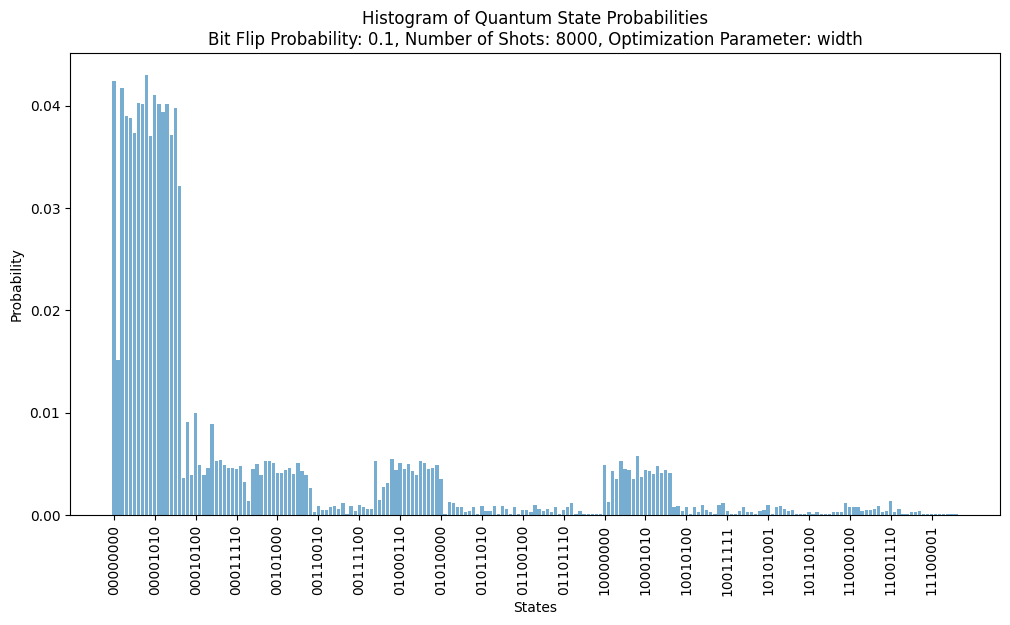

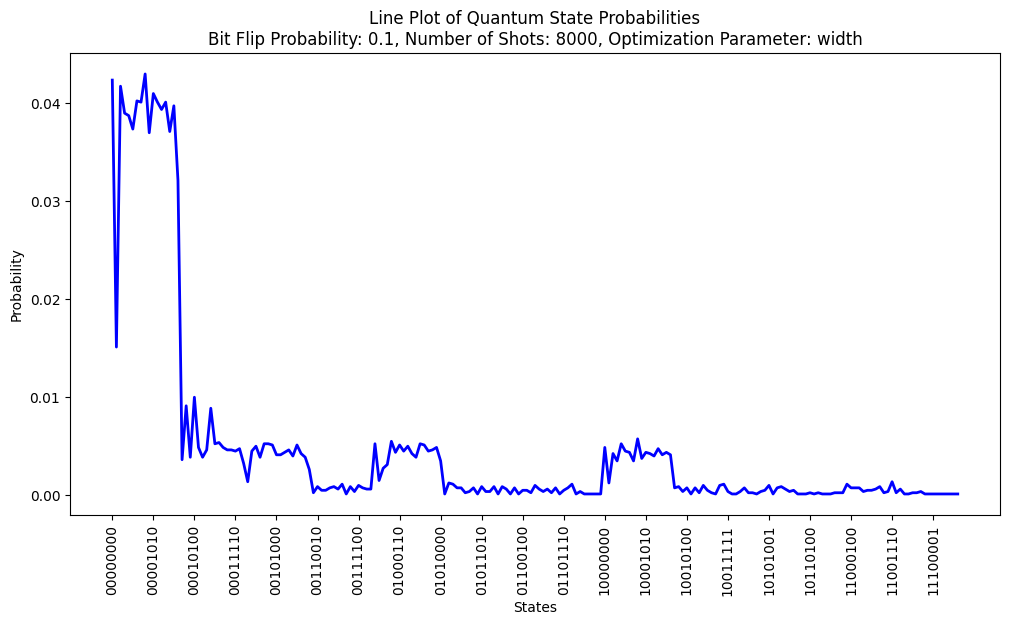

In [22]:
import matplotlib.pyplot as plt
from classiq.execution import ExecutionPreferences, NoiseProperties

# Define the noise properties
bit_flip_probability = 0.1
noise_props = NoiseProperties(
    measurement_bit_flip_probability=bit_flip_probability  # Example probability value
)

# Define the execution preferences
num_shots = 8000
exec_prefs = ExecutionPreferences(
    timeout_sec=600,  # Example timeout in seconds
    noise_properties=noise_props,
    num_shots=num_shots  # Number of shots for the execution
)

# Create the quantum model
qmod = create_model(main)

# Set the execution preferences for the quantum model
qmod = set_execution_preferences(qmod, exec_prefs)

# Define some optimization
optimization_parameter = "width"
quantum_model_with_constraints = set_constraints(
    qmod, Constraints(optimization_parameter=optimization_parameter),
)

# Synthesize the quantum model to get the quantum program
qprog = synthesize(qmod)

# Execute the quantum program and get the result
result = execute(qprog).result()[0].value

# Extract the counts
counts = result.counts

# Calculate the total number of counts
total_count = sum(counts.values())
print(f"Total count: {total_count}")

# Calculate probabilities
probabilities = {k: v / total_count for k, v in counts.items()}
print("Probabilities:", probabilities)

# Sort probabilities for a clean plot
sorted_probs = dict(sorted(probabilities.items()))

# Histogram Plot
plt.figure(figsize=(12, 6))
num_bins = len(sorted_probs)
x_ticks = range(num_bins)
x_labels = [''] * num_bins  # Empty labels to avoid crunched text

plt.bar(x_ticks, sorted_probs.values(), tick_label=x_labels, alpha=0.6)
plt.xlabel('States')
plt.ylabel('Probability')
plt.title('Histogram of Quantum State Probabilities\n'
          f'Bit Flip Probability: {bit_flip_probability}, '
          f'Number of Shots: {num_shots}, '
          f'Optimization Parameter: {optimization_parameter}')
plt.xticks(ticks=x_ticks[::max(1, num_bins // 20)], labels=list(sorted_probs.keys())[::max(1, num_bins // 20)], rotation=90)
plt.show()

# Line Plot
plt.figure(figsize=(12, 6))
plt.plot(x_ticks, sorted_probs.values(), color='blue', linestyle='-', linewidth=2)
plt.xlabel('States')
plt.ylabel('Probability')
plt.title('Line Plot of Quantum State Probabilities\n'
          f'Bit Flip Probability: {bit_flip_probability}, '
          f'Number of Shots: {num_shots}, '
          f'Optimization Parameter: {optimization_parameter}')
plt.xticks(ticks=x_ticks[::max(1, num_bins // 20)], labels=list(sorted_probs.keys())[::max(1, num_bins // 20)], rotation=90)
plt.show()


**THE EXECUTION USING THE THIRD METHOD:** (Using similar parameter as that of the second execution)

Node=0, prob vec =[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Node=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
Node=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
Node=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
Node=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
Node=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
Node=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
Node=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
Node=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0]
Node=1

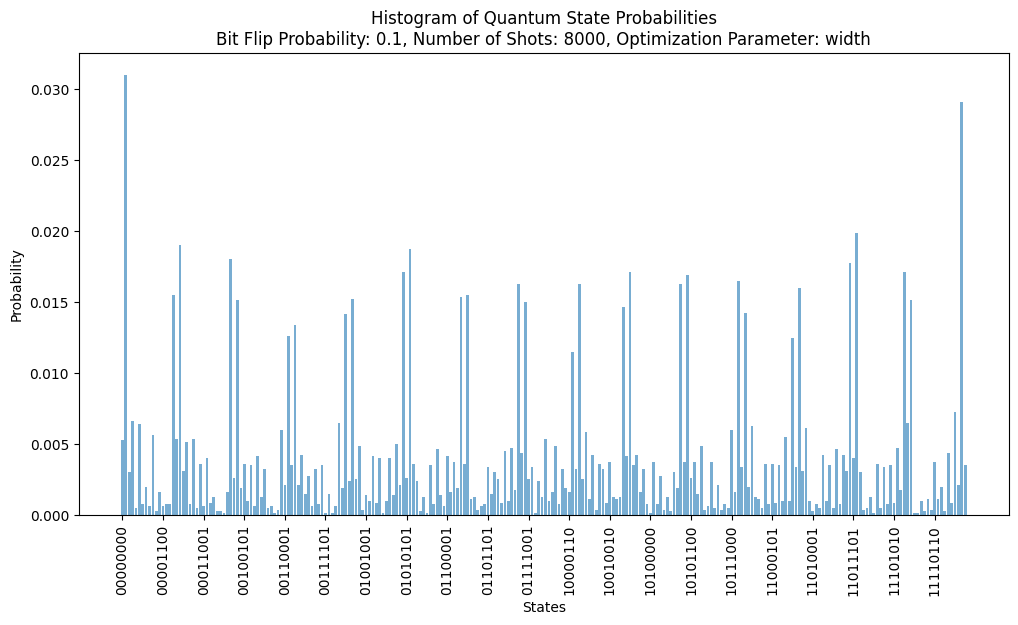

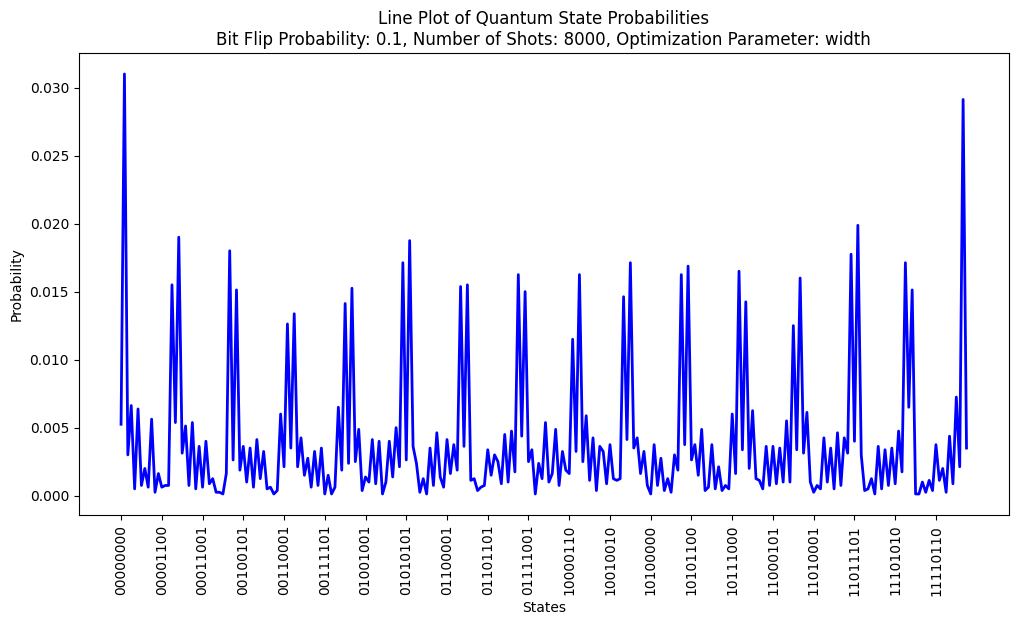

In [28]:
import matplotlib.pyplot as plt
from classiq.execution import ExecutionPreferences, NoiseProperties

# Define the noise properties
bit_flip_probability = 0.1
noise_props = NoiseProperties(
    measurement_bit_flip_probability=bit_flip_probability  # Example probability value
)

# Define the execution preferences
num_shots = 8000
exec_prefs = ExecutionPreferences(
    timeout_sec=600,  # Example timeout in seconds
    noise_properties=noise_props,
    num_shots=num_shots  # Number of shots for the execution
)

# Create the quantum model
qmod = create_model(main)

# Set the execution preferences for the quantum model
qmod = set_execution_preferences(qmod, exec_prefs)

# Define some optimization
optimization_parameter = "width"
quantum_model_with_constraints = set_constraints(
    qmod, Constraints(optimization_parameter=optimization_parameter),
)

# Synthesize the quantum model to get the quantum program
qprog = synthesize(qmod)

# Execute the quantum program and get the result
result = execute(qprog).result()[0].value

# Extract the counts
counts = result.counts

# Calculate the total number of counts
total_count = sum(counts.values())
print(f"Total count: {total_count}")

# Calculate probabilities
probabilities = {k: v / total_count for k, v in counts.items()}
print("Probabilities:", probabilities)

# Sort probabilities for a clean plot
sorted_probs = dict(sorted(probabilities.items()))

# Histogram Plot
plt.figure(figsize=(12, 6))
num_bins = len(sorted_probs)
x_ticks = range(num_bins)
x_labels = [''] * num_bins  # Empty labels to avoid crunched text

plt.bar(x_ticks, sorted_probs.values(), tick_label=x_labels, alpha=0.6)
plt.xlabel('States')
plt.ylabel('Probability')
plt.title('Histogram of Quantum State Probabilities\n'
          f'Bit Flip Probability: {bit_flip_probability}, '
          f'Number of Shots: {num_shots}, '
          f'Optimization Parameter: {optimization_parameter}')
plt.xticks(ticks=x_ticks[::max(1, num_bins // 20)], labels=list(sorted_probs.keys())[::max(1, num_bins // 20)], rotation=90)
plt.show()

# Line Plot
plt.figure(figsize=(12, 6))
plt.plot(x_ticks, sorted_probs.values(), color='blue', linestyle='-', linewidth=2)
plt.xlabel('States')
plt.ylabel('Probability')
plt.title('Line Plot of Quantum State Probabilities\n'
          f'Bit Flip Probability: {bit_flip_probability}, '
          f'Number of Shots: {num_shots}, '
          f'Optimization Parameter: {optimization_parameter}')
plt.xticks(ticks=x_ticks[::max(1, num_bins // 20)], labels=list(sorted_probs.keys())[::max(1, num_bins // 20)], rotation=90)
plt.show()


For validating the results: (THIRD METHOD)

In [29]:
# Process and print the results
print("Measurement results:")
counts = {}
vts = []
adj = []
pby = []
for sample in result.parsed_counts:
    vertices = sample.state["vertices"]
    vts.append(vertices)
    adjacent = sample.state["adjacent_vertices"]
    adj.append(adjacent)
    probability = sample.shots / result.num_shots
    pby.append(probability)
    state = (vertices, adjacent)
    counts[state] = probability
    print(f"Vertices: {vertices}, Adjacent: {adjacent}, Probability: {probability:.4f}")

def validate_results(counts):
    # Check if all states are valid (0-15 for both vertices and adjacent)
    valid_states = all(0 <= v < 16 and 0 <= a < 16 for v, a in counts.keys())

    # Check if there are no self-loops
    no_self_loops = all(v != a for v, a in counts.keys())

    # Check if only adjacent moves are allowed
    valid_moves = all(abs(v - a) == 1 for v, a in counts.keys() if counts[(v, a)] > 0)

    print("Validation Results:")
    print(f"All states valid: {'Yes' if valid_states else 'No'}")
    print(f"No self-loops: {'Yes' if no_self_loops else 'No'}")
    print(f"Only adjacent moves: {'Yes' if valid_moves else 'No'}")

validate_results(counts)

Measurement results:
Vertices: 1.0, Adjacent: 0.0, Probability: 0.0310
Vertices: 14.0, Adjacent: 15.0, Probability: 0.0291
Vertices: 14.0, Adjacent: 13.0, Probability: 0.0199
Vertices: 2.0, Adjacent: 1.0, Probability: 0.0190
Vertices: 6.0, Adjacent: 5.0, Probability: 0.0187
Vertices: 1.0, Adjacent: 2.0, Probability: 0.0180
Vertices: 12.0, Adjacent: 13.0, Probability: 0.0177
Vertices: 4.0, Adjacent: 5.0, Probability: 0.0171
Vertices: 13.0, Adjacent: 14.0, Probability: 0.0171
Vertices: 10.0, Adjacent: 9.0, Probability: 0.0171
Vertices: 11.0, Adjacent: 10.0, Probability: 0.0169
Vertices: 10.0, Adjacent: 11.0, Probability: 0.0165
Vertices: 6.0, Adjacent: 7.0, Probability: 0.0163
Vertices: 9.0, Adjacent: 10.0, Probability: 0.0163
Vertices: 9.0, Adjacent: 8.0, Probability: 0.0163
Vertices: 13.0, Adjacent: 12.0, Probability: 0.0160
Vertices: 7.0, Adjacent: 6.0, Probability: 0.0155
Vertices: 0.0, Adjacent: 1.0, Probability: 0.0155
Vertices: 5.0, Adjacent: 6.0, Probability: 0.0154
Vertices: 5.0

In [ ]:
write_qmod(qmod, "discrete_time_quantum_walk_16_nodes")

## The Circuit Diagram:

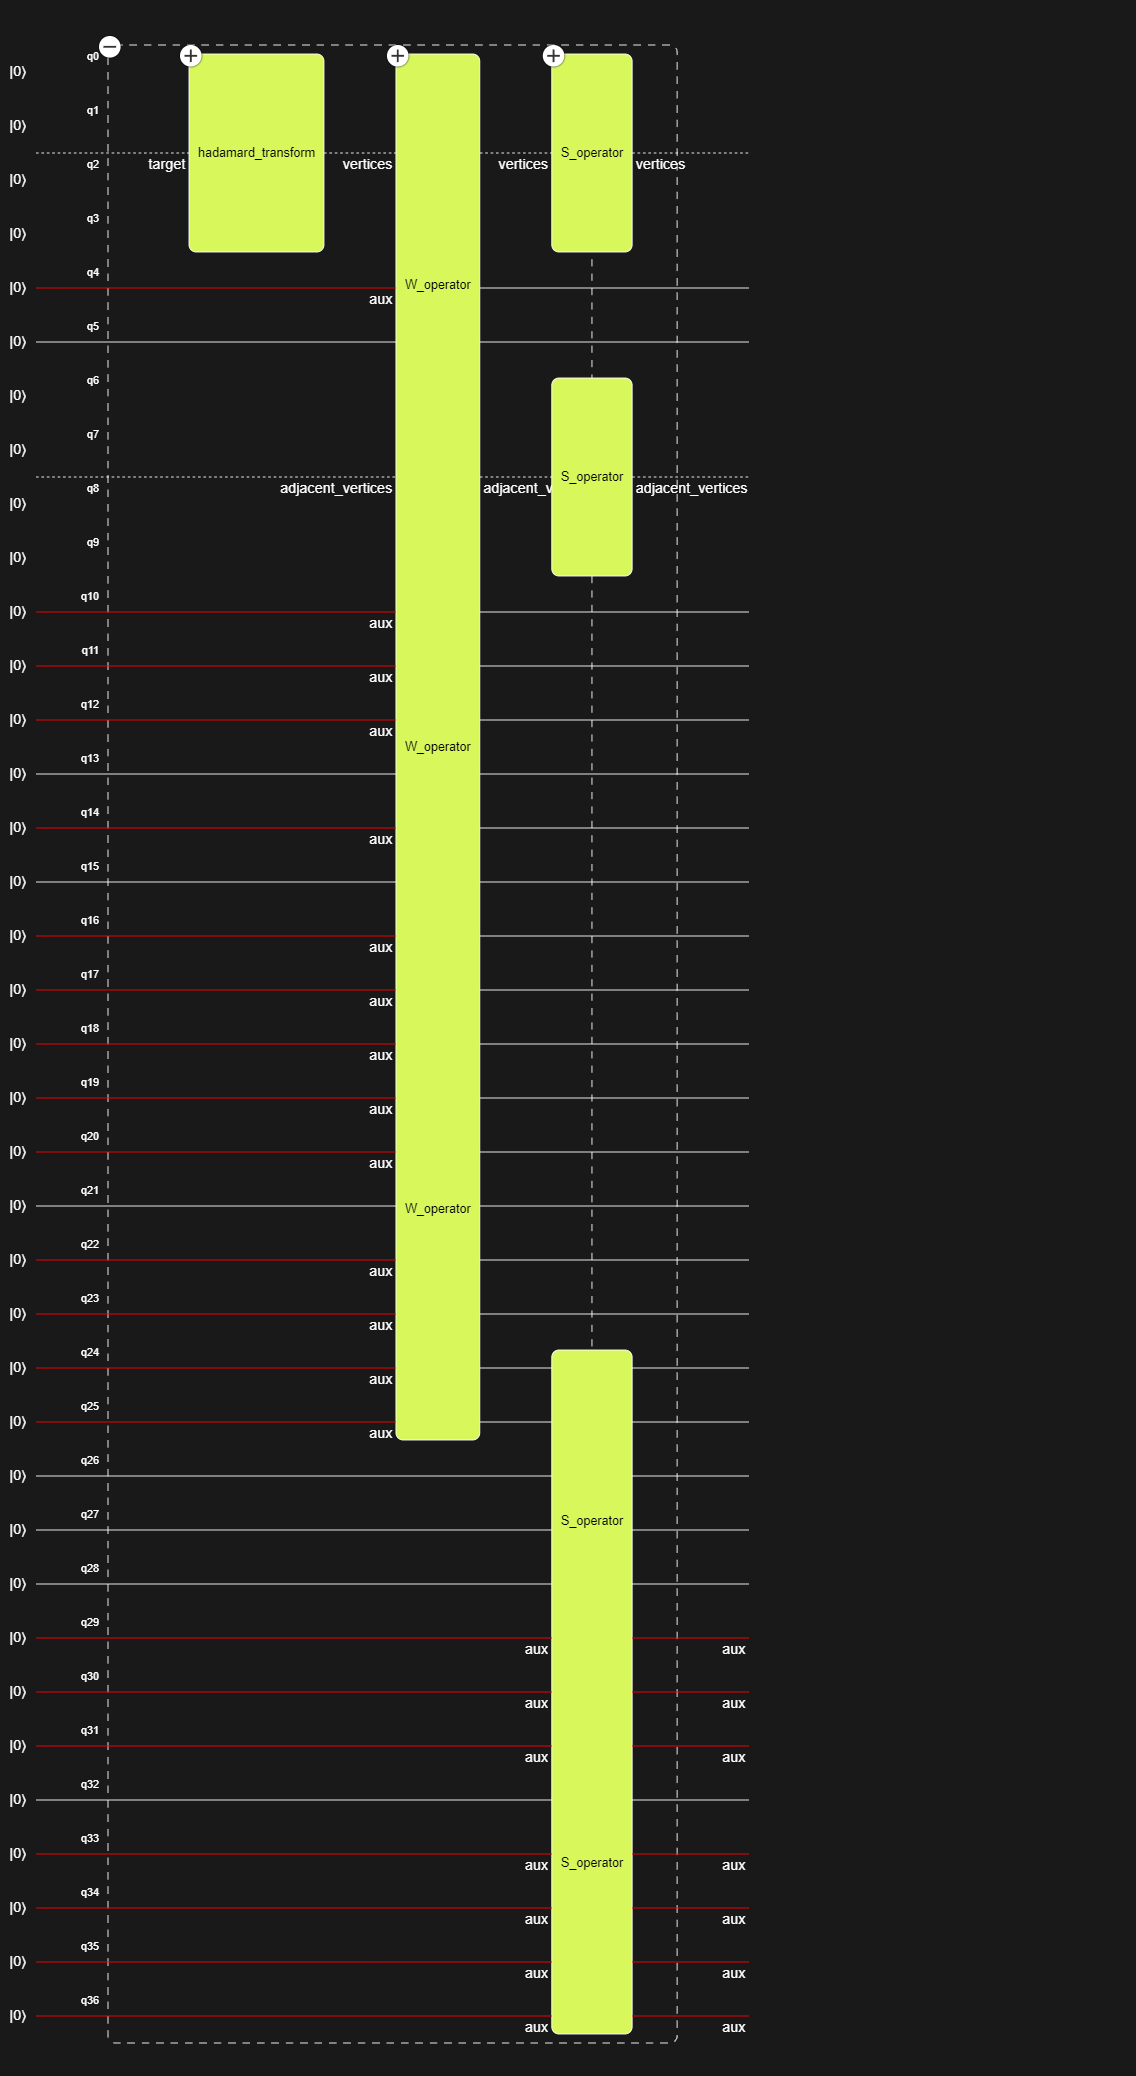

**NOTE**:  Now as we have seen with the first method (The actual method as dictated by the reference) there arises problem with the execution of this circuit, as the minimal circuit width for this is 37 which is more than the allowed simulator qubits, 25.

We therefore take a step backward and change our problem to creating a discrete time quantum walk with 8 nodes, to test our algorithm:
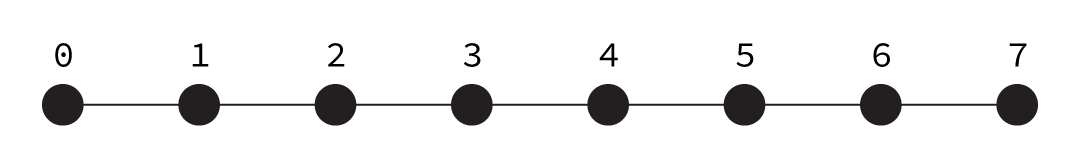

Implementing the whole code again with now size 3, to cover all the 8 nodes:

In [30]:
from classiq import *

# Number of qubits required for 16 nodes (2^4 = 16)
size = 3
nodes = 2**size

@qfunc
def prepare_minus(x: QBit):
    # Creates the |-⟩ state
    X(x)
    H(x)

@qfunc
def diffuzer_oracle(aux: Output[QBit], x: QNum):
    # Implements the diffusion oracle, flipping the aux qubit if x is non-zero
    aux ^= (x != 0)

@qfunc
def zero_diffuzer(x: QNum):
    # Applies the zero-state diffuser using an auxiliary qubit
    # Implements the (2|0⟩⟨0|−I)|0⟩ state
    aux = QNum('aux')
    allocate(1, aux)
    within_apply(compute=lambda: prepare_minus(aux),
                 action=lambda: diffuzer_oracle)

def W_iteration(i: int, vertices: QNum, adjacent_vertices: QNum):
    # Defines the iteration step for the walk operator
    prob = [0] * nodes
    if i == 0:  # Can only move to node 1
        prob[1] = 1
    elif i == nodes - 1:  # Can only move to node 6
        prob[-2] = 1
    else:  # Equal probability to move left or right
        prob[i-1] = 0.5
        prob[i+1] = 0.5

    print(f'Node={i}, prob vec ={prob}')

    # Applies the |j><j| ⊗ state
    control(ctrl=vertices == i,
            operand=lambda: within_apply(
                # Applies the |∂j⟩⟨∂j| state
                compute=lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
                action=lambda: zero_diffuzer(adjacent_vertices)))

@qfunc
def W_operator(vertices: QNum, adjacent_vertices: QNum):
    # Applies W_iteration for all possible vertex states (0 to 7)
    for i in range(2**size):
        W_iteration(i, vertices, adjacent_vertices)



@qfunc
def edge_oracle(res: Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    # Determines if two vertices are adjacent in the line
    # Sets the result qubit if the difference between vertices is 1 or -1
    res |= (((vertices - adjacent_vertices) == 1) | ((vertices - adjacent_vertices) == -1))

@qfunc
def bitwise_swap(x: QArray[QBit], y: QArray[QBit]):
    # Swaps corresponding qubits between two quantum registers
    repeat(count=x.len,
           iteration=lambda i: SWAP(x[i], y[i]))

@qfunc
def S_operator(vertices: QNum, adjacent_vertices: QNum):
    # Implements the swap operator based on the edge oracle
    # If vertices are adjacent, their states are swapped
    res = QNum('res')
    edge_oracle(res, vertices, adjacent_vertices)
    control(ctrl=res == 1, operand=lambda: bitwise_swap(vertices, adjacent_vertices))



@qfunc
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):
    # Allocates and initializes the quantum registers
    allocate(size, vertices)
    # Creates superposition of all vertices
    hadamard_transform(vertices)
    allocate(size, adjacent_vertices)

    # Applies the W_operator followed by the S_operator
    W_operator(vertices, adjacent_vertices)
    S_operator(vertices, adjacent_vertices)

# Creates a quantum model from the main function
qmod = create_model(main)
# Synthesizes the quantum program
qprog = synthesize(qmod)
# # Displays the resulting quantum circuit
# show(qprog)

# write_qmod(qmod, "discrete_time_quantum_walk_8_nodes")

Node=0, prob vec =[0, 1, 0, 0, 0, 0, 0, 0]
Node=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0]
Node=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0]
Node=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0]
Node=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0]
Node=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0]
Node=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5]
Node=7, prob vec =[0, 0, 0, 0, 0, 0, 1, 0]


Let's look at the execution results:

In [31]:
job = execute(qprog)
results = job.result()

print(results[0].value.counts)
print()
print(results[0].value.parsed_states)

{'000110': 265, '001000': 267, '000101': 222, '000100': 270, '000000': 246, '000010': 242, '000111': 282, '000011': 254}

{'000110': {'vertices': 6.0, 'adjacent_vertices': 0.0}, '001000': {'vertices': 0.0, 'adjacent_vertices': 1.0}, '000101': {'vertices': 5.0, 'adjacent_vertices': 0.0}, '000100': {'vertices': 4.0, 'adjacent_vertices': 0.0}, '000000': {'vertices': 0.0, 'adjacent_vertices': 0.0}, '000010': {'vertices': 2.0, 'adjacent_vertices': 0.0}, '000111': {'vertices': 7.0, 'adjacent_vertices': 0.0}, '000011': {'vertices': 3.0, 'adjacent_vertices': 0.0}}


Now we consider three optimization methods:
- No Optimization
- Optimization by Width
- Optimization by CX Counts

Node=0, prob vec =[0, 1, 0, 0, 0, 0, 0, 0]
Node=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0]
Node=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0]
Node=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0]
Node=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0]
Node=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0]
Node=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5]
Node=7, prob vec =[0, 0, 0, 0, 0, 0, 1, 0]
Node=0, prob vec =[0, 1, 0, 0, 0, 0, 0, 0]
Node=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0]
Node=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0]
Node=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0]
Node=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0]
Node=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0]
Node=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5]
Node=7, prob vec =[0, 0, 0, 0, 0, 0, 1, 0]
Node=0, prob vec =[0, 1, 0, 0, 0, 0, 0, 0]
Node=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0]
Node=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0]
Node=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0]
Node=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0]
Node=5, prob vec =[0, 0, 0, 0, 0.

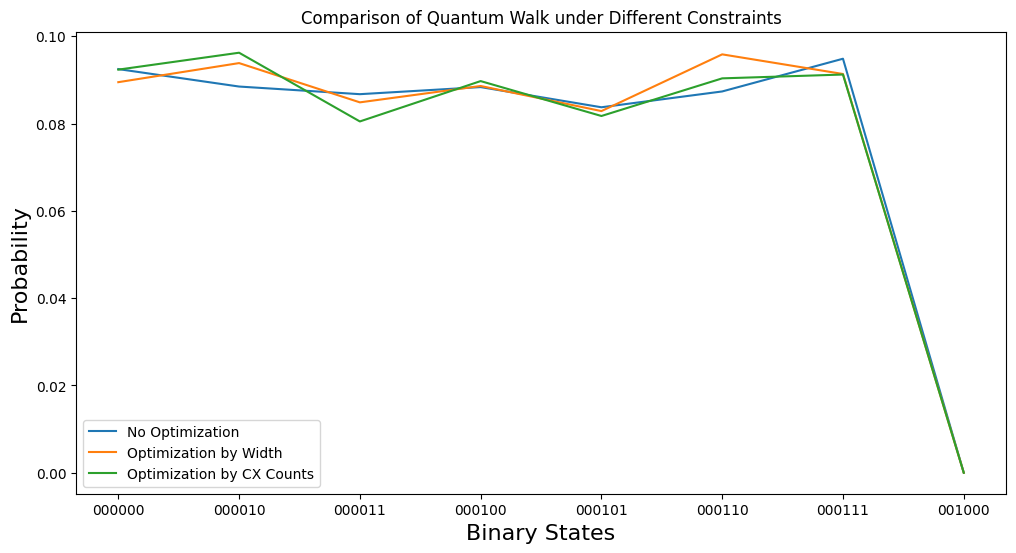

In [37]:
from classiq import *
import matplotlib.pyplot as plt
import numpy as np
from classiq.execution import ExecutionPreferences, NoiseProperties

# Number of qubits required for 8 nodes (2^3 = 8)
size = 3
nodes = 2**size

@qfunc
def prepare_minus(x: QBit):
    # Creates the |-⟩ state
    X(x)
    H(x)

@qfunc
def diffuzer_oracle(aux: Output[QBit], x: QNum):
    # Implements the diffusion oracle, flipping the aux qubit if x is non-zero
    aux ^= (x != 0)

@qfunc
def zero_diffuzer(x: QNum):
    # Applies the zero-state diffuser using an auxiliary qubit
    # Implements the (2|0⟩⟨0|−I)|0⟩ state
    aux = QNum('aux')
    allocate(1, aux)
    within_apply(compute=lambda: prepare_minus(aux),
                 action=lambda: diffuzer_oracle)

def W_iteration(i: int, vertices: QNum, adjacent_vertices: QNum):
    # Defines the iteration step for the walk operator
    prob = [0] * nodes
    if i == 0:  # Can only move to node 1
        prob[1] = 1
    elif i == nodes - 1:  # Can only move to node 6
        prob[-2] = 1
    else:  # Equal probability to move left or right
        prob[i-1] = 0.5
        prob[i+1] = 0.5

    print(f'Node={i}, prob vec ={prob}')

    # Applies the |j><j| ⊗ state
    control(ctrl=vertices == i,
            operand=lambda: within_apply(
                # Applies the |∂j⟩⟨∂j| state
                compute=lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
                action=lambda: zero_diffuzer(adjacent_vertices)))

@qfunc
def W_operator(vertices: QNum, adjacent_vertices: QNum):
    # Applies W_iteration for all possible vertex states (0 to 7)
    for i in range(2**size):
        W_iteration(i, vertices, adjacent_vertices)

@qfunc
def edge_oracle(res: Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    # Determines if two vertices are adjacent in the line
    # Sets the result qubit if the difference between vertices is 1 or -1
    res |= (((vertices - adjacent_vertices) == 1) | ((vertices - adjacent_vertices) == -1))

@qfunc
def bitwise_swap(x: QArray[QBit], y: QArray[QBit]):
    # Swaps corresponding qubits between two quantum registers
    repeat(count=x.len,
           iteration=lambda i: SWAP(x[i], y[i]))

@qfunc
def S_operator(vertices: QNum, adjacent_vertices: QNum):
    # Implements the swap operator based on the edge oracle
    # If vertices are adjacent, their states are swapped
    res = QNum('res')
    edge_oracle(res, vertices, adjacent_vertices)
    control(ctrl=res == 1, operand=lambda: bitwise_swap(vertices, adjacent_vertices))

@qfunc
def main(vertices: Output[QNum], adjacent_vertices: Output[QNum]):
    # Allocates and initializes the quantum registers
    allocate(size, vertices)
    # Creates superposition of all vertices
    hadamard_transform(vertices)
    allocate(size, adjacent_vertices)

    # Applies the W_operator followed by the S_operator
    W_operator(vertices, adjacent_vertices)
    S_operator(vertices, adjacent_vertices)

# Preferences, Constraints, Noises

# Define the noise properties
bit_flip_probability = 0.1
noise_props = NoiseProperties(
    measurement_bit_flip_probability=bit_flip_probability  # Example probability value
)

# Define the execution preferences
num_shots = 8000
exec_prefs = ExecutionPreferences(
    timeout_sec=600,  # Example timeout in seconds
    noise_properties=noise_props,
    num_shots=num_shots  # Number of shots for the execution
)

# Function to run the model with specific constraints and return the probabilities
def run_model_with_constraints(constraints):
    # Create and set constraints
    qmod = create_model(main)
    quantum_model_with_constraints = set_constraints(qmod, constraints)
    quantum_model_with_constraints = set_execution_preferences(quantum_model_with_constraints, exec_prefs)

    # Synthesize and execute the model
    qprog = synthesize(quantum_model_with_constraints)
    job = execute(qprog)
    results = job.result()

    # Extract the counts from the results
    counts = results[0].value.counts

    # Process the results to get the probabilities
    probabilities = np.zeros(nodes)
    total_counts = sum(counts.values())
    for key, count in counts.items():
        position = int(key, 2)
        if position < nodes:
            probabilities[position] = count / total_counts

    return probabilities

# Different constraint scenarios
constraints_list = [
    Constraints(optimization_parameter="no_opt"),
    Constraints(optimization_parameter="width"),
    Constraints(optimization_parameter="cx"),
]

# Run the model for each constraint scenario and store the results
results_dict = {}
for i, constraints in enumerate(constraints_list):
    results_dict[f"Scenario {i+1}"] = run_model_with_constraints(constraints)

# Processed values for plotting
example_counts = {'000110': 265, '001000': 267, '000101': 222, '000100': 270, '000000': 246, '000010': 242, '000111': 282, '000011': 254}
total_counts = sum(example_counts.values())
example_probabilities = {k: v / total_counts for k, v in example_counts.items()}

# Sort keys for consistent plotting
sorted_keys = sorted(example_probabilities.keys())

# Plot the results with clear labels for each optimization method
plt.figure(figsize=(12, 6))

scenario_labels = {
    "Scenario 1": "No Optimization",
    "Scenario 2": "Optimization by Width",
    "Scenario 3": "Optimization by CX Counts"
}

for scenario in results_dict:
    probabilities = [results_dict[scenario][int(key, 2)] if int(key, 2) < nodes else 0 for key in sorted_keys]
    plt.plot(sorted_keys, probabilities, label=scenario_labels[scenario])

plt.xlabel('Binary States', fontsize=16)
plt.ylabel('Probability', fontsize=16)
plt.legend()
plt.title("Comparison of Quantum Walk under Different Constraints")
plt.show()
